# Seq2Seq_Attension
實現機器翻譯(Machine Translation)，輸入一句英文句子，輸出一句法文句子
<br>輸入 : his least liked fruit is the apple , but your least liked is the strawberry .
<br>輸出 : son fruit est moins aimé la pomme , mais votre moins aimé est la fraise .
<br>在這支程式中加入Attension機制，強化Seq2Seq

本程式試著不使用Tensorflow所提供的Helper指令，完成Scheduled Sampling<br>
Scheduled Sampling是一種解決訓練和生成時輸入數據分布不一致的方法<br>

在一般的Seq2Seq模型的inference階段中，如果Sequence中在t時刻中產生錯誤的值，在t時刻之後的輸入狀態將會受到影響，而該誤差會隨著生成過程不斷向後累積；而Scheduled Sampling以一定概率將Decoder自己產生的值作為Decoder端的輸入，這樣即使前面產生錯誤的值，其目標仍然是最大化真實目標序列的概率，模型會朝著正確的方向進<br>

在訓練早期Scheduled Sampling主要使用target中的真實值作為Decoder端的輸入，可以將模型從隨機初始化的狀態快速引導至一個合理的狀態；隨著訓練的進行，該方法會逐漸更多地使用Decoder自己產生的值作為Decoder端的輸入，以解決數據分布不一致的問題<br>

<img src="2_scheduled_sampling_attension_不使用helper指令_version_1.jpg" style="width:1140px;height:600px;float:middle">
以上為Decoder端的計算流程<br>
contex_vecotr = attention(mlstm_cell_output , encoder的output)<br>
而contex_vecotr會輸入至下一個時刻decoder_cell<br>
但這是稍微簡便的作法<br>
以下為完整的作法的計算流程

<img src="2_scheduled_sampling_attension_不使用helper指令_version_2.jpg" style="width:1140px;height:600px;float:middle">

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import time
import tensorflow as tf
import copy
import random
from tensorflow.python.layers.core import Dense
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

# 讀取數據

In [2]:
# English source data
f_eng = open('data/small_vocab_en', 'r', encoding='utf-8')
source_letter = []
source_sentence = []
while True:
    raw = f_eng.readline()
    if raw == '' : break

    sentence = raw.split('\n')[0] 
    temp_sentence = []
    for word in sentence.split(' '):
        if len(word) != 0:
            source_letter.append(word.lower())
            temp_sentence.append(word.lower())
    source_sentence.append(temp_sentence)      
    
# French target data
f_fre = open('data/small_vocab_fr', 'r', encoding='utf-8')       
target_letter = []
target_sentence = []
while True:
    raw = f_fre.readline()
    if raw == '' : break

    sentence = raw.split('\n')[0]   
    temp_sentence = []
    for word in sentence.split(' '):
        if len(word) != 0:
            target_letter.append(word.lower())
            temp_sentence.append(word.lower())
    target_sentence.append(temp_sentence)

# 數據預處理

In [3]:
special_words = ['<PAD>' , '<UNK>' , '<GO>' , '<EOS>']

# 建造英文詞庫
source_letter = list(set(source_letter)) + special_words[:2] # 加入 '<PAD>' , '<UNK>'              
source_letter_to_int = {word : idx for idx , word in enumerate(source_letter)}   
source_int_to_letter = {idx : word for idx , word in enumerate(source_letter)}   

# 建造法文詞庫
target_letter = list(set(target_letter)) + special_words # 加入 '<PAD>' , '<UNK>' , '<GO>' , '<EOS>'       
target_letter_to_int = {word : idx for idx , word in enumerate(target_letter)}   
target_int_to_letter = {idx : word for idx , word in enumerate(target_letter)}

In [4]:
# 將所有英文詞彙轉換成index
source_int = []
for sentence in source_sentence:
    temp = []
    for letter in sentence:
        if letter in source_letter_to_int.keys():
            temp.append(source_letter_to_int[letter])  
        else:
            temp.append(source_letter_to_int['<UNK>'])
    source_int.append(temp)           

# 將所有英文詞彙轉換成index
target_int = []
for sentence in target_sentence:
    temp = []
    for letter in sentence:
        if letter in target_letter_to_int.keys():
            temp.append(target_letter_to_int[letter])
        else:
            temp.append(target_letter_to_int['<UNK>'])
    temp.append(target_letter_to_int['<EOS>'])    
    target_int.append(temp)  

In [5]:
# 決定source_int與target_int中的最大長度
# 因為後面的decoder的rnn不是使用tf.nn.dynamic_rnn，無法使用動態長度的功能，所以在這裡就要決定每個batch的長度
source_max_length , target_max_length = 0 , 0  
for vob_source , vob_target in zip(source_int , target_int):
    if len(vob_source) > source_max_length:
        source_max_length = len(vob_source)    
    if len(vob_target) > target_max_length:
        target_max_length = len(vob_target)  

# 分別對source_int與target_int_pad 補source_letter_to_int['<PAD>']與target_letter_to_int['<PAD>']到最大長度  
source_int_pad , target_int_pad = [] , []
for source_sentence , target_sentence in zip(source_int , target_int):
    temp_source = source_sentence.copy()
    while len(temp_source) < source_max_length:
        temp_source.append(source_letter_to_int['<PAD>']) 
    source_int_pad.append(temp_source)
    
    temp_target = target_sentence.copy()
    while len(temp_target) < target_max_length:
        temp_target.append(target_letter_to_int['<PAD>']) 
    target_int_pad.append(temp_target)       

source_int_pad = np.array(source_int_pad)
target_int_pad = np.array(target_int_pad)

In [6]:
# 超參數
# Number of Epochs
epochs = 200
# Batch Size
batch_size = 130
# Attention Size
att_size = 40
# RNN Size
rnn_hidden_unit = 128
# Number of Layers
num_layers = 1
# Embedding Size
encoding_embedding_size = 100
decoding_embedding_size = rnn_hidden_unit
source_vocab_size = len(source_int_to_letter)
target_vocab_size = len(target_int_to_letter)

# Build Model

## 輸入層

In [7]:
input_data = tf.placeholder(tf.int32, [None , source_max_length] , name = 'inputs')
targets = tf.placeholder(tf.int32, [None , target_max_length] , name = 'targets')
targets_onehot = tf.one_hot(tf.reshape(targets , [-1]) , depth = target_vocab_size , name = 'targets_onehot')
target_sequence_length = tf.placeholder(tf.int32 , [None ,] , name = 'target_sequence_length')

# 決定到底是"t-1階段的輸出"還是"target中的真實答案"，當作t階段的輸入
from_model_or_target = tf.placeholder(tf.bool , [target_max_length , ] , name = 'from_model_or_target')

## Encoder

需要對source數據進行embedding，再傳入Decoder中的RNN

In [8]:
encoder_embeddings = tf.Variable(tf.random_uniform([source_vocab_size , encoding_embedding_size]))
encoder_embed_input = tf.nn.embedding_lookup(encoder_embeddings , input_data)

def get_lstm_cell(rnn_hidden_unit):
    lstm_cell = tf.contrib.rnn.LSTMCell(rnn_hidden_unit, 
                                        initializer = tf.random_uniform_initializer(-0.1 , 0.1))
    return lstm_cell

with tf.variable_scope('encoder'):   
    encoder_cell = tf.contrib.rnn.MultiRNNCell([get_lstm_cell(rnn_hidden_unit) for _ in range(num_layers)])
    
    encoder_output, encoder_state = tf.nn.dynamic_rnn(encoder_cell , 
                                                      encoder_embed_input , 
                                                      dtype = tf.float32)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


## Decoder and Attention

In [9]:
# 預處理後的decoder輸入
# 在batch中每一筆data最前面加上<GO>，並移除最後一個字，所以每一筆data的詞的數目並無改變

ending = tf.identity(targets[: , 0:-1])
decoder_input = tf.concat([tf.fill([batch_size, 1] , target_letter_to_int['<GO>']) , ending] , axis = 1)

In [10]:
# 1. Embedding
decoder_embeddings = tf.Variable(tf.random_uniform([target_vocab_size, decoding_embedding_size]))
decoder_embed_input = tf.nn.embedding_lookup(decoder_embeddings , decoder_input)

with tf.variable_scope('decoder'):
    # 2. 建構Decoder中的RNN
    decoder_cell = tf.contrib.rnn.MultiRNNCell([get_lstm_cell(rnn_hidden_unit) for _ in range(num_layers)])
    state = encoder_state 
    outputs  = []
    final_outputs  = []
    attention_matrix = []
    for time_step in range(0 , target_max_length):
        if time_step > 0: tf.get_variable_scope().reuse_variables()  
            
        # 在訓練的過程中，除了time_step為0以外，每一個time_step都投擲硬幣決定
        # 要用decoder_embed_input[: , time_step , :](target中的真實答案)，還是mlstm_cell_output(machine自己產生的output)，輸入decoder_cell
        # 正面代表當前時刻decoder_cell要吃decoder_embed_input[: , time_step , :](target中的真實答案)
        # 反面代表當前時刻decoder_cell要吃mlstm_cell_output(上一個時刻decoder_cell的輸出)
        # 也就是coin tossing為[True , True , True , True , True , True , True , True]會逐漸變為[Faslse , Faslse , Faslse , Faslse , Faslse , Faslse , Faslse , Faslse]
        # 前幾個epoch會有很大的機率擲出正面，但隨著訓練的過程擲出反面的機率會越來越大
        # 在後面的步驟會調節擲出正反面的機率
        if time_step == 0: 
            input_to_decoder = decoder_embed_input[: , 0 , :]
            mlstm_cell_output , state = decoder_cell(input_to_decoder , state)
                
        elif time_step > 0: 
            input_to_decoder = tf.cond(from_model_or_target[time_step] , 
                                       lambda: decoder_embed_input[: , time_step , :] , 
                                       lambda: mlstm_cell_output)
            mlstm_cell_output , state = decoder_cell(input_to_decoder , state) # mlstm_cell_output → [batch_size , rnn_hidden_unit] 
        
        
        with tf.variable_scope('attention'):
            if time_step > 0: tf.get_variable_scope().reuse_variables()
            W_1 = tf.get_variable(initializer = tf.truncated_normal([rnn_hidden_unit , att_size] , mean = 0.001 , stddev = 0.3) ,
                                  name = 'w_1') 
            W_2 = tf.get_variable(initializer = tf.truncated_normal([rnn_hidden_unit , att_size] , mean = 0.001 , stddev = 0.3) ,
                                  name = 'w_2')       
            V = tf.get_variable(initializer = tf.truncated_normal([att_size , 1] , mean = 0.001 , stddev = 0.3) ,
                                name = 'V')
            
            # a → [2 , 3 , 3] 
            # b → [3 , 2 , 6]
            # c = tf.tensordot(a , b , axes = 1)  → [2 , 3 , 2 , 6]
            score = tf.nn.tanh(tf.tensordot(encoder_output , W_1 , axes = 1) + \
                               tf.expand_dims(tf.tensordot(mlstm_cell_output , W_2 , axes = 1) , 1)) # score → [batch_size , source_max_length , att_size]     
            score = tf.tensordot(score , V , axes = 1) # score → [batch_size , source_max_length , 1]
            
            attention_weights = tf.nn.softmax(score , axis = 1) # attention_weights → [batch_size , source_max_length , 1]       
            context_vector = tf.multiply(attention_weights , encoder_output) # context_vector → [batch_size , source_max_length , rnn_hidden_unit]      
            context_vector = tf.reduce_sum(context_vector , axis = 1) # context_vector → [batch_size , rnn_hidden_unit]            
        
        final_outputs.append(context_vector)
        final_outputs_ = tf.transpose(tf.convert_to_tensor(final_outputs) , [1 , 0 , 2]) # final_outputs_ → [batch_size , target_max_length , rnn_hidden_unit]    
        final_outputs_ = tf.reshape(final_outputs_ , [-1 , rnn_hidden_unit]) 
        
        # tf.squeeze(attention_weights , [-1]) : [batch_size , source_max_length , 1] → [batch_size , source_max_length] 
        attention_matrix.append(tf.squeeze(attention_weights , [-1])) # 把每一個time_step的attention_weights收集起來成為attention_matrix

In [11]:
with tf.variable_scope('fully_connected_layer'):
    weights = tf.Variable(tf.truncated_normal([rnn_hidden_unit , target_vocab_size] , mean = 0.01 , stddev = 0.1))
    biases = tf.Variable(tf.zeros([1 , target_vocab_size]) + 0.0001)
    logits = tf.matmul(final_outputs_ , weights) + biases 

predicting_logits = tf.nn.softmax(logits , axis = 1)   
predicting_logits = tf.argmax(predicting_logits , axis = 1)
predicting_logits = tf.reshape(predicting_logits , [batch_size , -1] , name = 'predictions')
attention_matrix = tf.transpose(tf.convert_to_tensor(attention_matrix) , [1 , 2 , 0] , name = 'attention_weight') # attention_matrix => [batch_size , source_max_length , target_max_length]  

In [12]:
with tf.variable_scope('optimization'):
    masks = tf.sequence_mask(target_sequence_length ,
                             target_max_length ,
                             dtype = tf.float32,
                             name = 'masks')
    
    # Loss function
    loss = tf.nn.softmax_cross_entropy_with_logits(labels = targets_onehot , logits = logits)
    loss = tf.reshape(loss , [-1 , target_max_length])
    loss = tf.multiply(loss , masks)
    loss = tf.reduce_mean(loss)

    # Optimizer
    optimizer = tf.train.AdamOptimizer(1e-3)

    # Gradient Clipping
    gradients = optimizer.compute_gradients(loss)
    capped_gradients = [(tf.clip_by_value(grad , -1. , 1.) , var) for grad , var in gradients if grad is not None]
    train_op = optimizer.apply_gradients(capped_gradients)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [13]:
# 將數據集分割為train和validation
train_source = source_int_pad[batch_size:]
train_target = target_int_pad[batch_size:]
# 留出一個batch進行驗證
valid_source = source_int_pad[:batch_size]
valid_target = target_int_pad[:batch_size]
valid_target_length =\
np.array(list(map(lambda x: len([y for y in x if y != target_letter_to_int['<PAD>']]) , valid_target)))

## Training

In [14]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

prob = 1e-3
alpha = 1.2
stop_early = 0
for epoch_i in range(0 , epochs):
    
    # 在每進行一個epoch前，把每個batch的index先決定出來
    batch_index = []
    temp = []
    count = 0 
    while len(batch_index) <= 1059:  
        temp.append(count)
        count += 1
        if len(temp) == batch_size:
            batch_index.append(temp)
            temp = []
        if count == len(train_source):
            count = 0
    
    # 一開始會出現[True , True , True , True , True , True , True , True]
    # 隨著epoch的增長，逐漸開始出現[Faslse , Faslse , Faslse , Faslse , Faslse , Faslse , Faslse , Faslse]
    # 在Decoder端的訓練，一開始t階段的輸入為t-1階段的期望輸出(Teacher Forcing)，到最後逐漸變為t階段的輸入為t-1階段的輸出(Sampling)
    coin_tossing = np.random.choice(a = 2 , 
                                    size = target_max_length , 
                                    replace = True , 
                                    p = [prob , 1 - prob])
    coin_tossing = coin_tossing.astype(bool)
    if alpha * prob < 1  : prob = alpha * prob # p會隨著epoch增加越來越大
    elif alpha * prob > 1: prob = 1.        

    for batch_i in range(0 , 1059):
        train_source_batch , train_target_batch =\
        train_source[batch_index[batch_i] , :] , train_target[batch_index[batch_i] , :] 
        train_target_length =\
        np.array(list(map(lambda x: len([y for y in x if y != 0]) , train_target_batch)))
        
        _ , training_loss =\
        sess.run([train_op , loss],
                 feed_dict = {input_data : train_source_batch ,
                              targets : train_target_batch ,
                              target_sequence_length : train_target_length ,
                              from_model_or_target : coin_tossing})
   
    validation_loss , predicting_logits_result =\
    sess.run([loss , predicting_logits] ,
             feed_dict = {input_data : valid_source ,
                          targets : valid_target ,
                          target_sequence_length : valid_target_length , 
                          from_model_or_target : coin_tossing}) 

    print('=' *  30)
    print('Epoch : {}/{} \nTraining Loss : {:.3f} \nValidation loss: {:.3f} \nstop_early : {} \ncoin_tossing_True_num : {}'
          .format(epoch_i , epochs ,
                  training_loss , validation_loss , 
                  stop_early , 
                  coin_tossing.sum()))

    index = np.random.randint(batch_size)

    source_visualization = []
    for i in valid_source[index]:
        if source_int_to_letter[i] == '<PAD>': break
        source_visualization.append(source_int_to_letter[i])
    source_visualization = ' '.join(source_visualization)

    target_visualization = []
    for i in valid_target[index]:
        if target_int_to_letter[i] == '<EOS>': break
        target_visualization.append(target_int_to_letter[i])
    target_visualization = ' '.join(target_visualization)

    predict_visualization = []
    for i in predicting_logits_result[index]:
        if target_int_to_letter[i] == '<EOS>': break
        predict_visualization.append(target_int_to_letter[i])
    predict_visualization = ' '.join(predict_visualization)
    
    print('*' *  30)
    print('Source  : {}'.format(source_visualization))
    print('Target  : {}'.format(target_visualization))
    print('Predict : {}\n'.format(predict_visualization))

    if coin_tossing.sum() == 0:
        stop_early += 1

    if stop_early == 20: # 當coin_tossing全部為False的次數為20時即停止計算
        break

# 保存模型
saver = tf.train.Saver()
saver.save(sess , 'trained_model/save_net')
print('Model Trained and Saved')   

Epoch : 0/200 
Training Loss : 0.530 
Validation loss: 0.527 
stop_early : 0 
coin_tossing_True_num : 24
******************************
Source  : the apple is our least favorite fruit , but the orange is her least favorite .
Target  : la pomme est notre fruit préféré moins , mais l'orange est son moins préféré .
Predict : la pomme est notre fruit préféré moins , mais la est notre moins préféré .

Epoch : 1/200 
Training Loss : 0.378 
Validation loss: 0.358 
stop_early : 0 
coin_tossing_True_num : 24
******************************
Source  : the strawberry is their least favorite fruit , but the apple is our least favorite.
Target  : la fraise est leur fruit préféré moins , mais la pomme est notre moins préféré .
Predict : la fraise est leur fruit préféré moins , mais la fraise est son moins préféré .

Epoch : 2/200 
Training Loss : 0.281 
Validation loss: 0.261 
stop_early : 0 
coin_tossing_True_num : 24
******************************
Source  : paris is never pleasant during september ,

Epoch : 20/200 
Training Loss : 0.019 
Validation loss: 0.017 
stop_early : 0 
coin_tossing_True_num : 24
******************************
Source  : california is never cold during may , and it is sometimes chilly in march .
Target  : californie ne fait jamais froid au mois de mai , et il est parfois frisquet en mars .
Predict : californie ne fait jamais froid au mois de mai , et il est parfois frisquet en mars .

Epoch : 21/200 
Training Loss : 0.021 
Validation loss: 0.019 
stop_early : 0 
coin_tossing_True_num : 23
******************************
Source  : they are going to france next june .
Target  : ils vont en france en juin prochain .
Predict : ils vont en france en avril prochain .

Epoch : 22/200 
Training Loss : 0.027 
Validation loss: 0.032 
stop_early : 0 
coin_tossing_True_num : 22
******************************
Source  : the strawberry is his least favorite fruit , but the peach is our least favorite .
Target  : la fraise est son fruit préféré moins , mais la pêche est notr

Epoch : 40/200 
Training Loss : 0.135 
Validation loss: 0.157 
stop_early : 2 
coin_tossing_True_num : 0
******************************
Source  : the orange is her least liked fruit , but the grapefruit is their least liked .
Target  : l'orange est la moins aimé des fruits , mais le pamplemousse est leur moins aimé .
Predict : l'orange est le moins aimé des fruits , mais le pamplemousse est leur moins aimé .

Epoch : 41/200 
Training Loss : 0.101 
Validation loss: 0.134 
stop_early : 3 
coin_tossing_True_num : 0
******************************
Source  : california is never cold during february , but it is sometimes freezing in june .
Target  : californie ne fait jamais froid en février , mais il est parfois le gel en juin .
Predict : californie ne fait jamais froid en février , mais il est parfois le gel en juin .

Epoch : 42/200 
Training Loss : 0.105 
Validation loss: 0.120 
stop_early : 4 
coin_tossing_True_num : 0
******************************
Source  : paris is never busy during s

the mango is your least liked fruit , but the apple is my least liked .
votre moins aimé fruit est le raisin , mais mon moins aimé est la pomme . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>


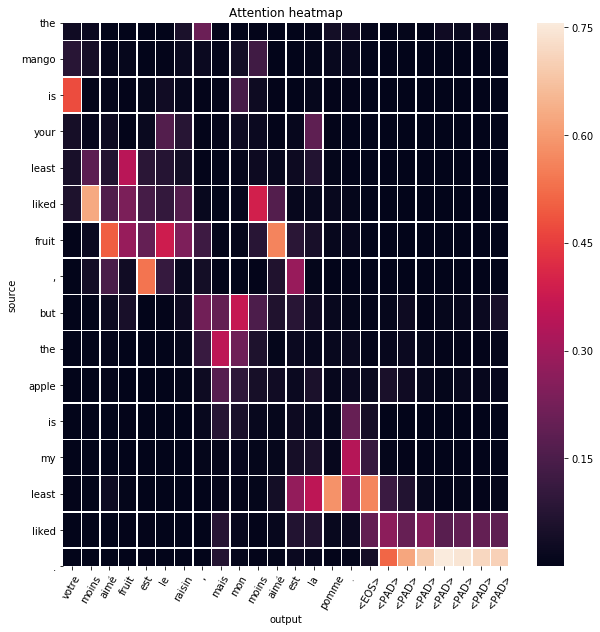

In [15]:
att , predicting_logits_ = sess.run([attention_matrix  , predicting_logits],
                                     feed_dict = {input_data : valid_source ,
                                                  targets : valid_target ,
                                                  from_model_or_target : coin_tossing})    

# 隨機取一個樣本 i 畫出注意力矩陣
i = 4
matrix = att[i , : , :]
matrix = matrix[1: , :]
src =  train_source_batch[i, :]
tgt = predicting_logits_[i , :]    

src_letter , tgt_letter = [] , []
for item in src:
    src_letter.append(source_int_to_letter[item])
src_letter = src_letter[:-1]   
for item in tgt :
    tgt_letter.append(target_int_to_letter[item])
print(' '.join(src_letter))
print(' '.join(tgt_letter))

df = pd.DataFrame(matrix , index = src_letter , columns = tgt_letter)
plt.figure(figsize=(10 , 10))
ax = sns.heatmap(df , linewidths = 0.5)
ax.set_xlabel('output')
ax.set_ylabel('source')
plt.xticks(rotation = 60)
plt.yticks(rotation = 0)
ax.set_title('Attention heatmap')
plt.show()

## Testing

In [17]:
import os    
sess = tf.Session()
new_saver = tf.train.import_meta_graph(os.path.join('trained_model/save_net.meta'))
new_saver.restore(sess, tf.train.latest_checkpoint(os.path.join('trained_model')))

graph = tf.get_default_graph()
input_data = graph.get_tensor_by_name('inputs:0')
targets = graph.get_tensor_by_name('targets:0')
logits = graph.get_tensor_by_name('predictions:0')
from_model_or_target = graph.get_tensor_by_name('from_model_or_target:0')

# 注意input_sentence的長度不能大於訓練語料庫的句子的最大長度
input_sentence = 'i dislike grapefruit , lemons , and peaches .'
test_source = []
for letter in input_sentence.split(' '):
    if letter in source_letter_to_int.keys():
        test_source.append(source_letter_to_int[letter])
    elif letter not in source_letter_to_int.values():
        test_source.append(source_letter_to_int['<UNK>'])

# 輸入的句子的長度是固定source_max_length，所以補source_letter_to_int['<PAD>']到長度為source_max_length
while len(test_source) < source_max_length:
    test_source.append(source_letter_to_int['<PAD>'])
test_source = [test_source] * batch_size

# test_target輸入的值可以隨便選，只要長度為target_max_length即可
test_target = [0 for _ in range(0 , target_max_length)] 
test_target = [test_target] * batch_size

test_source = np.array(test_source)
test_target = np.array(test_target)
coin_tossing = [False for _ in range(0 , target_max_length)]
answer = sess.run(logits, feed_dict = {input_data : test_source ,
                                       targets : test_target ,
                                       from_model_or_target : coin_tossing})

answer = answer[0 , :]
answer_to_letter = []
for num in answer:
    if target_int_to_letter[num] == '<EOS>': break
    answer_to_letter.append(target_int_to_letter[num])

print('輸入的英文句子 : {}'.format(input_sentence))  
print('google翻譯的法文句子 : {}'.format("je n'aime pamplemousses , les citrons et les pêches ."))  
print('model翻譯的法文句子  : {}'.format(' '.join(answer_to_letter)))

INFO:tensorflow:Restoring parameters from trained_model\save_net
輸入的英文句子 : i dislike grapefruit , lemons , and peaches .
google翻譯的法文句子 : je n'aime pamplemousses , les citrons et les pêches .
model翻譯的法文句子  : je n'aime pamplemousses , les citrons et les pêches .
